#### Notebook to analyse the delay in observed acceleration of sea level

I think what I would do in this case is gradually expand the time series from t=19xx towards 19xx+1 etc and calculate after adding a single year whether in a least square fitting approach the acceleration term is significant and remains significant after adding new years. Repeat this for the time serie without the wind effect and look at the difference between the two results and consider that as the delay. Probably you have too much noise in this procedure so I guess filtering a bit is needed. I suspect it will learn you in the end whether the delay is 5,10,20 or  40 years or something like that which seems a useful number for the discussions with Fedor and co.

In [127]:
# import necessary packages
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

from sklearn.feature_selection import f_regression

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/iriskeizer/Projects/ClimatePhysics/Thesis/Github/Thesis-KNMI/Wind_contribution/Comparison/code')

import import_data as imprt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import data

In [75]:
# Import tide gauge data file

tg_data = imprt.import_obs_slh_data()

In [76]:
# Import regression results

timeseries_np_era5, timeseries_tim_era5, timeseries_dang_era5 = imprt.import_reg_results('timeseries', 'era5')
timeseries_np_20cr, timeseries_tim_20cr, timeseries_dang_20cr = imprt.import_reg_results('timeseries', '20cr')

#### Obtain wind corrected tide gauge data

In [77]:
regression_models = ['NearestPoint', 'Timmerman', 'Dangendorf']
timeseries_reg_models_era5 = [timeseries_np_era5, timeseries_tim_era5, timeseries_dang_era5]
timeseries_reg_models_20cr = [timeseries_np_20cr, timeseries_tim_20cr, timeseries_dang_20cr]

In [78]:
lst_20cr = []
lst_era5 = []
for k, rm in enumerate(regression_models):
    tg_data_corr_20cr = tg_data.loc[:2015].copy()
    tg_data_corr_era5 = tg_data.loc[1950:].copy()
    for station in tg_data.columns:
        
        tg_data_corr_20cr[station] = tg_data_corr_20cr[station] + timeseries_reg_models_20cr[k][station, 'wind total'].loc[1890:2015]
        tg_data_corr_era5[station] = tg_data_corr_era5[station] + timeseries_reg_models_era5[k][station, 'wind total']
        
    lst_20cr.append(tg_data_corr_20cr)
    lst_era5.append(tg_data_corr_era5)

tg_data_corr_era5 = pd.concat(lst_era5, axis=1, keys = regression_models)
tg_data_corr_20cr = pd.concat(lst_20cr, axis=1, keys = regression_models)

#### Plot non-smoothed corrected tide gauge data

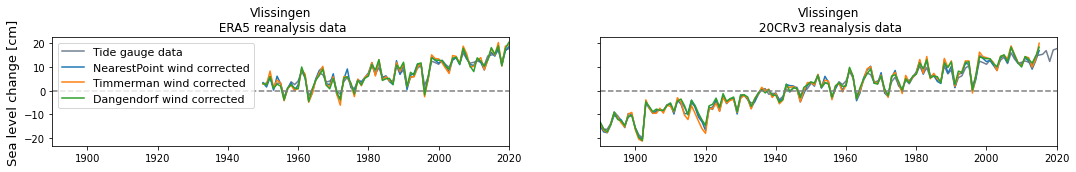

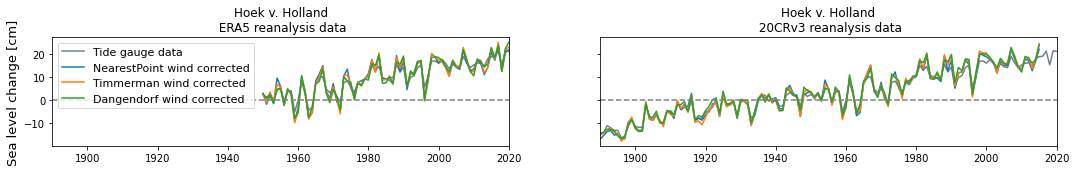

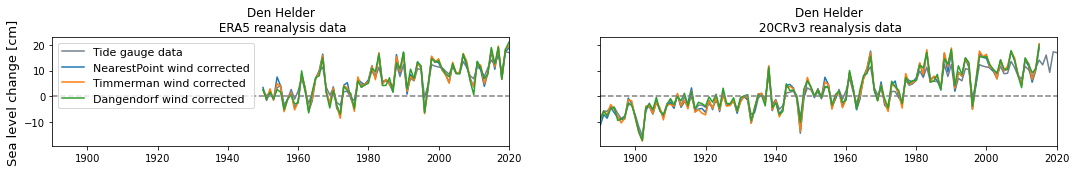

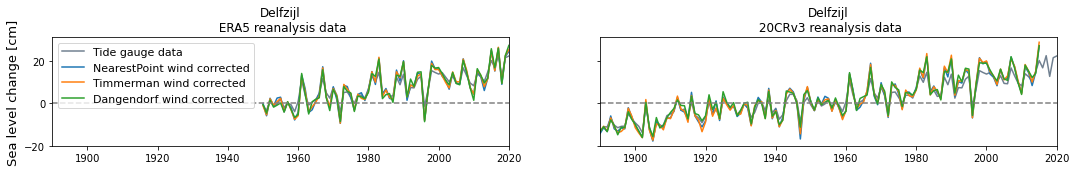

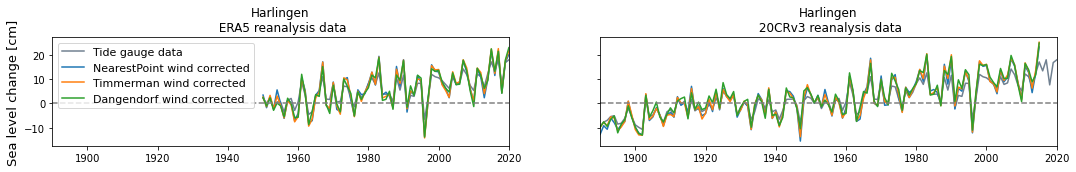

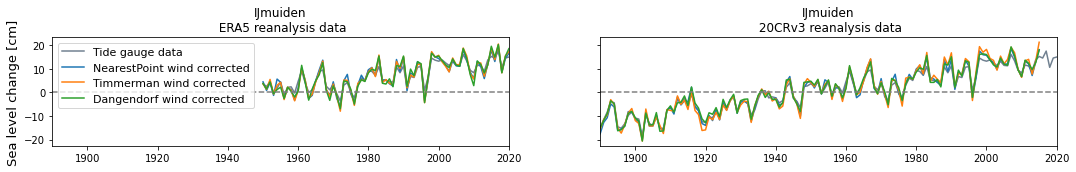

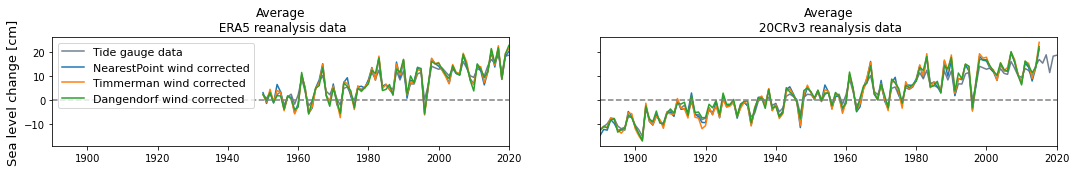

In [79]:
fsize = 13

for station in tg_data.columns:

    f, axes = plt.subplots(1, 2, sharey = True, figsize = (18,2))
    
    ax = axes[0]
    ax.plot(tg_data.loc[1950:].index, tg_data.loc[1950:][station].values, label = 'Tide gauge data', color = 'slategray')
    for rm in regression_models:
        ax.plot(tg_data_corr_era5.index, tg_data_corr_era5[rm, station].values, label = rm+' wind corrected')
    ax.set_xlim(1890, 2020)
    ax.set_ylabel('Sea level change [cm]', fontsize = fsize)
    ax.set_title(station + '\n ERA5 reanalysis data')
    ax.axhline(color='gray', linestyle = '--')
    ax.legend(fontsize = 11)
    
    ax = axes[1]
    ax.plot(tg_data.index, tg_data[station].values, color = 'slategray')
    for rm in regression_models:
        ax.plot(tg_data_corr_20cr.index, tg_data_corr_20cr[rm, station].values)
    ax.set_xlim(1890, 2020)
    ax.set_title(station + '\n 20CRv3 reanalysis data')
    ax.axhline(color='gray', linestyle = '--')
    

#### Plot 11y LOWESS smoothed corrected tide gauge data

In [80]:
window = 11 # years
lowess = sm.nonparametric.smoothers_lowess.lowess

In [81]:
# Obtain smoothed dataframes
tg_data_sm_20cr = tg_data.loc[1890:2015].copy()
tg_data_sm_era5 = tg_data.loc[1950:2020].copy()
tg_data_corr_sm_20cr = tg_data_corr_20cr.copy()
tg_data_corr_sm_era5 = tg_data_corr_era5.copy()

for station in tg_data.columns:
    tg_data_sm_20cr[station] = lowess(tg_data_sm_20cr[station],
                                      tg_data_sm_20cr.index.values,
                                      window/tg_data_sm_20cr.index.size,
                                      return_sorted = False)
    tg_data_sm_era5[station] = lowess(tg_data_sm_era5[station],
                                      tg_data_sm_era5.index.values,
                                      window/tg_data_sm_era5.index.size,
                                      return_sorted = False)
    
    for rm in regression_models:
        tg_data_corr_sm_20cr[rm, station] = lowess(tg_data_corr_sm_20cr[rm, station],
                                          tg_data_corr_sm_20cr.index.values,
                                          window/tg_data_corr_sm_20cr.index.size,
                                          return_sorted = False)
        tg_data_corr_sm_era5[rm, station] = lowess(tg_data_corr_sm_era5[rm, station],
                                          tg_data_corr_sm_era5.index.values,
                                          window/tg_data_corr_sm_era5.index.size,
                                          return_sorted = False)

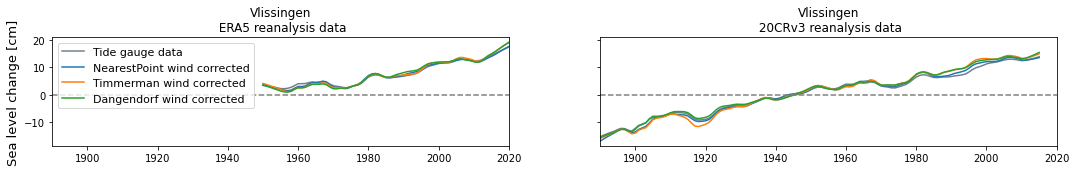

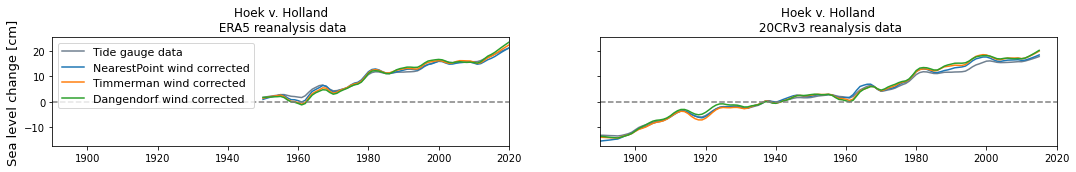

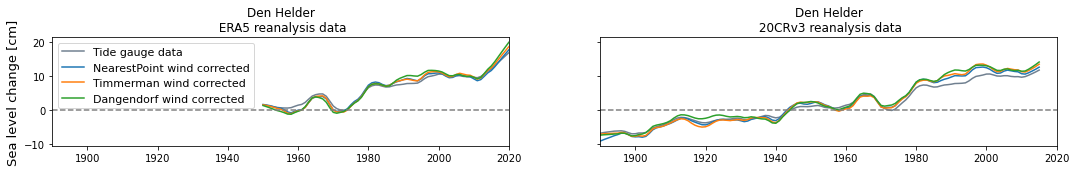

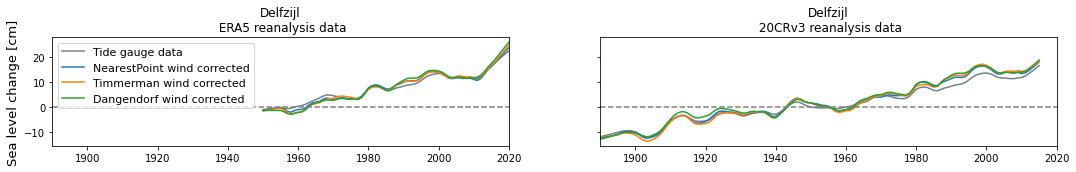

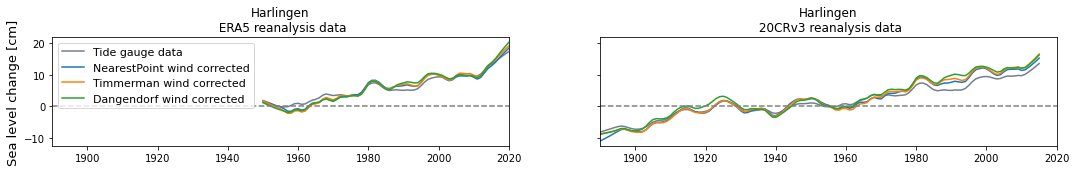

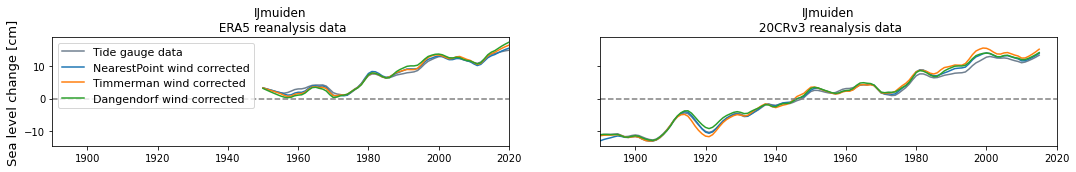

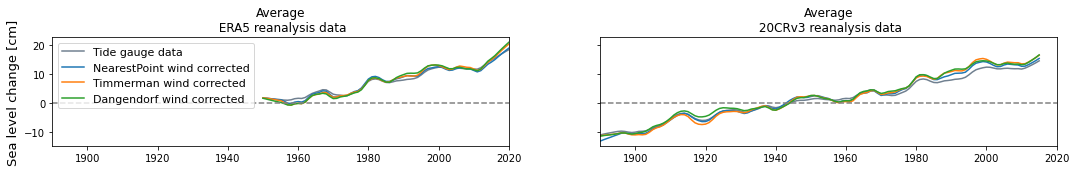

In [82]:
fsize = 13

for station in tg_data.columns:

    f, axes = plt.subplots(1, 2, sharey = True, figsize = (18,2))
    
    ax = axes[0]
    ax.plot(tg_data_sm_era5.index, tg_data_sm_era5[station].values, label = 'Tide gauge data', color = 'slategray')
    for rm in regression_models:
        ax.plot(tg_data_corr_sm_era5.index, tg_data_corr_sm_era5[rm, station].values, label = rm+' wind corrected')
    ax.set_xlim(1890, 2020)
    ax.set_ylabel('Sea level change [cm]', fontsize = fsize)
    ax.set_title(station + '\n ERA5 reanalysis data')
    ax.axhline(color='gray', linestyle = '--')
    ax.legend(fontsize = 11)
    
    ax = axes[1]
    ax.plot(tg_data_sm_20cr.index, tg_data_sm_20cr[station].values, color = 'slategray')
    for rm in regression_models:
        ax.plot(tg_data_corr_sm_20cr.index, tg_data_corr_sm_20cr[rm, station].values)
    ax.set_xlim(1890, 2020)
    ax.set_title(station + '\n 20CRv3 reanalysis data')
    ax.axhline(color='gray', linestyle = '--')
    

#### Obtain the acceleration for the overlapping period between ERA5 and 20CRv3 [1950-2015] for non-smoothed 

It should be calculated whether the raw sea level data has a significant acceleration term
and whether the corrections using ERA5 and 20CRv3 data and NearestPoint, Timmerman or Dangendorf regression model have significant acceleration terms.

Do this first for only the average station



Used: https://joshualoong.com/2018/10/03/Fitting-Polynomial-Regressions-in-Python/

In [83]:
station = 'Average'
degree = 2

x = tg_data.index.values
y = tg_data[station].values

df = pd.DataFrame(columns=['y', 'x'])
df['x'] = x
df['y'] = y

weights = np.polyfit(x, y, degree)
model = np.poly1d(weights)
results = smf.ols(formula='y ~ model(x)', data=df).fit()



In [84]:
weights

array([ 2.65326708e-04, -8.44406796e-01,  6.38097702e+02])

In [85]:
data_lst = [tg_data[station], tg_data_corr_era5['NearestPoint', station], tg_data_corr_era5['Timmerman', station], 
            tg_data_corr_era5['Dangendorf', station], tg_data_corr_20cr['NearestPoint', station], 
            tg_data_corr_20cr['Timmerman', station], tg_data_corr_20cr['Dangendorf', station]]

name_lst = ['tg_data', 'np_era5', 'tim_era5', 'dang_era5', 'np_20cr', 'tim_20cr', 'dang_20cr']

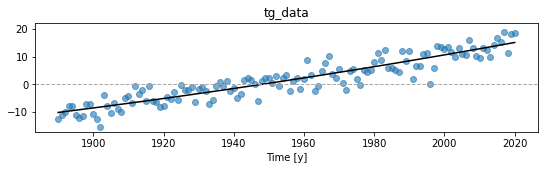

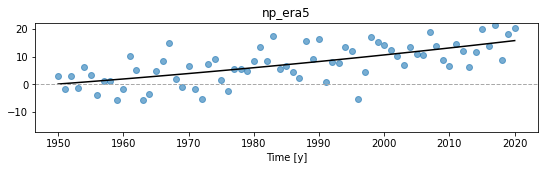

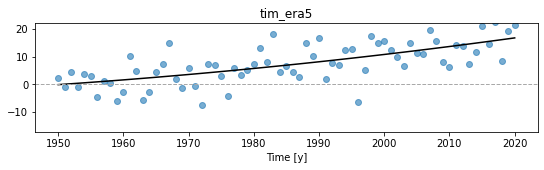

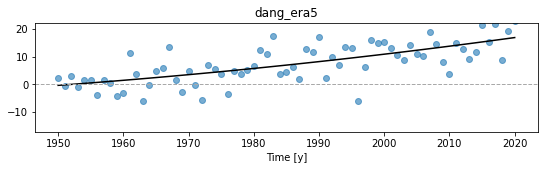

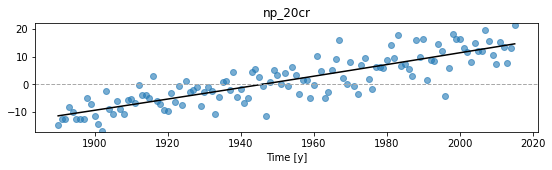

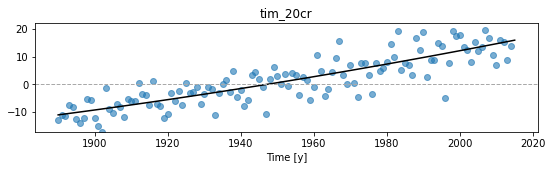

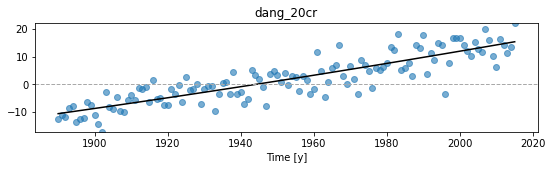

In [86]:
df = pd.DataFrame({'result':['coef_0', 'coef_1', 'coef_2', 'p_val']})
df_acc = df.set_index('result')

for k, data in enumerate(data_lst):
    x = data.index.values
    y = data.values
    
    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = x
    df['y'] = y
    
    weights = np.polyfit(x, y, degree)
    model = np.poly1d(weights)
    results = smf.ols(formula='y ~ model(x)', data=df).fit()

    df_acc[name_lst[k]] = list(weights) + [results.pvalues[1]]
    
    plt.figure(figsize=(9,2))
    plt.scatter(data.index, data.values, alpha = .6)
    plt.plot(data.index, model(data.index), color = 'k')
    plt.axhline(color='darkgrey', linestyle='--', linewidth = 1)
    plt.title(name_lst[k])
    plt.xlabel('Time [y]')
    plt.ylim(-17, 22)

In [ ]:
y_pred = results.predict(x)
plt.plot(x,ypred)

ERROR! Session/line number was not unique in database. History logging moved to new session 388


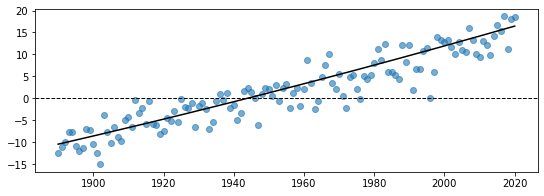

In [87]:
plt.figure(figsize=(9,3))
plt.scatter(tg_data.index, tg_data[station], alpha = .6)
plt.plot(tg_data.index, model(tg_data.index), color = 'k')
plt.axhline(color='k', linestyle='--', linewidth = 1)

In [88]:
list(weights)

[0.00017120930261633227, -0.46225359157271273, 251.59313738087832]

In [89]:
# Obtain significance acceleration term from 1950 - 1980, 1981, 1982, ...

df = pd.DataFrame({'final year':range(1950, 2016)})
df_acc = df.set_index('final year')



In [90]:
for k, data in enumerate(data_lst):
    x = data.index.values
    y = data.values
    
    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = x
    df['y'] = y
    
    weights = np.polyfit(x, y, degree)
    model = np.poly1d(weights)
    results = smf.ols(formula='y ~ model(x)', data=df).fit()

    df_acc[name_lst[k]] = list(weights) + [results.pvalues[1]]
    
    plt.figure(figsize=(9,2))
    plt.scatter(data.index, data.values, alpha = .6)
    plt.plot(data.index, model(data.index), color = 'k')
    plt.axhline(color='darkgrey', linestyle='--', linewidth = 1)
    plt.title(name_lst[k])
    plt.xlabel('Time [y]')
    plt.ylim(-17, 22)

ValueError: Length of values (4) does not match length of index (66)

In [124]:
station = 'Average'
degree = 2

x = tg_data.index.values
y = tg_data[station].values

df = pd.DataFrame(columns=['y', 'x'])
df['x'] = x
df['y'] = y

weights = np.polyfit(x, y, degree)

df_contributions = pd.DataFrame(columns = ['acceleration'])
df_contributions['acceleration'] = weights[0] * x**2
#df_contributions['trend'] = weights[1] * x
#df_contributions['constant'] = weights[0]*np.ones(x.size)

In [93]:
acc_contribution = weights[0] * x

In [125]:


f_statistic, p_values = f_regression(df_contributions, y)

In [126]:
p_values

array([2.76640158e-14])

#### Obtain significance of acceleration term over periods 1950 - 1980,1981,1982,...

In [143]:
station = 'Average'
degree = 2
years = range(1980, 2000)
significance_level = 95
alpha = 1-significance_level/100

In [133]:
# Select data from 1950 onwards
tg_data = tg_data.loc[1950:2015]
tg_data_corr_era5 = tg_data_corr_era5.loc[1950:2015]
tg_data_corr_20cr = tg_data_corr_20cr.loc[1950:2015]

In [134]:
# Create dataframe of data
name_lst = ['tg_data', 'np_era5', 'tim_era5', 'dang_era5', 'np_20cr', 'tim_20cr', 'dang_20cr']
df_tg_data = pd.DataFrame(columns = name_lst)
df_tg_data['tg_data'] = tg_data[station]
df_tg_data['np_era5'] = tg_data_corr_era5['NearestPoint', station]
df_tg_data['tim_era5'] = tg_data_corr_era5['Timmerman', station]
df_tg_data['dang_era5'] = tg_data_corr_era5['Dangendorf', station]
df_tg_data['np_20cr'] = tg_data_corr_20cr['NearestPoint', station]
df_tg_data['tim_20cr'] = tg_data_corr_20cr['Timmerman', station]
df_tg_data['dang_20cr'] = tg_data_corr_20cr['Dangendorf', station]

In [138]:
df_acc_sign = pd.DataFrame(columns = ['final year']+name_lst)
df_acc_sign['final year'] = years
df_acc_sign = df_acc_sign.set_index('final year')

df_acc_pval = df_acc_sign.copy()

In [148]:


for year in years:
    
    for column in df_acc_sign.columns:
        
        # Define x and y
        x = df_tg_data.loc[:year].index.values
        y = df_tg_data.loc[:year][column].values
        
        # Obtain coefficients from fit
        weights = np.polyfit(x, y, degree)
        
        # Create dataframe to obtain p-values
        df_contributions = pd.DataFrame(columns = ['acceleration'])
        df_contributions['acceleration'] = weights[0] * x**2
        
        # Obtain p-values
        f_statistic, p_values = f_regression(df_contributions, y)
        
        # Add p-values to dataframe
        df_acc_pval[column][year] = p_values[0]
        
        # Add significance to dataframe
        if p_values[0]<alpha:
            df_acc_sign[column][year] = True
        else:
            df_acc_sign[column][year] = False

In [149]:
df_acc_pval

,tg_data,np_era5,tim_era5,dang_era5,np_20cr,tim_20cr,dang_20cr
final year,,,,,,,
1980,0.062251,0.176151,0.226275,0.175887,0.133991,0.148265,0.09424
1981,0.016689,0.065592,0.085805,0.062726,0.045771,0.048889,0.029439
1982,0.006191,0.038954,0.0501,0.023949,0.024599,0.024613,0.009974
1983,0.001395,0.009797,0.012119,0.005296,0.005871,0.005449,0.002063
1984,0.001037,0.009033,0.012209,0.006058,0.004965,0.006106,0.002371
1985,0.000753,0.007281,0.009453,0.006308,0.003886,0.004541,0.002423
1986,0.000693,0.00834,0.009809,0.004689,0.004183,0.00376,0.001745
1987,0.000825,0.012782,0.013306,0.007739,0.006958,0.005664,0.003486
1988,0.000188,0.003674,0.004021,0.002518,0.001907,0.001492,0.001027


In [150]:
df_acc_sign

,tg_data,np_era5,tim_era5,dang_era5,np_20cr,tim_20cr,dang_20cr
final year,,,,,,,
1980,False,False,False,False,False,False,False
1981,True,False,False,False,True,True,True
1982,True,True,False,True,True,True,True
1983,True,True,True,True,True,True,True
1984,True,True,True,True,True,True,True
1985,True,True,True,True,True,True,True
1986,True,True,True,True,True,True,True
1987,True,True,True,True,True,True,True
1988,True,True,True,True,True,True,True


#### Obtain significance of acceleration term over periods 1900 - 1980,1981,1982,...

In [165]:
station = 'Average'
degree = 2
years = range(1960, 2000)
significance_level = 95
alpha = 1-significance_level/100

In [166]:
# Select data from 1900 onwards
tg_data = tg_data.loc[1900:2015]
tg_data_corr_20cr = tg_data_corr_20cr.loc[1900:2015]

In [167]:
# Create dataframe of data
name_lst = ['tg_data', 'np_20cr', 'tim_20cr', 'dang_20cr']
df_tg_data = pd.DataFrame(columns = name_lst)
df_tg_data['tg_data'] = tg_data[station]
df_tg_data['np_20cr'] = tg_data_corr_20cr['NearestPoint', station]
df_tg_data['tim_20cr'] = tg_data_corr_20cr['Timmerman', station]
df_tg_data['dang_20cr'] = tg_data_corr_20cr['Dangendorf', station]

In [168]:
df_acc_sign = pd.DataFrame(columns = ['final year']+name_lst)
df_acc_sign['final year'] = years
df_acc_sign = df_acc_sign.set_index('final year')

df_acc_pval = df_acc_sign.copy()

In [169]:


for year in years:
    
    for column in df_acc_sign.columns:
        
        # Define x and y
        x = df_tg_data.loc[:year].index.values
        y = df_tg_data.loc[:year][column].values
        
        # Obtain coefficients from fit
        weights = np.polyfit(x, y, degree)
        
        # Create dataframe to obtain p-values
        df_contributions = pd.DataFrame(columns = ['acceleration'])
        df_contributions['acceleration'] = weights[0] * x**2
        
        # Obtain p-values
        f_statistic, p_values = f_regression(df_contributions, y)
        
        # Add p-values to dataframe
        df_acc_pval[column][year] = p_values[0]
        
        # Add significance to dataframe
        if p_values[0]<alpha:
            df_acc_sign[column][year] = True
        else:
            df_acc_sign[column][year] = False

In [170]:
df_acc_pval

,tg_data,np_20cr,tim_20cr,dang_20cr
final year,,,,
1960,0.550129,0.152759,0.122571,0.074963
1961,0.419365,0.977293,0.985002,0.817818
1962,0.314799,0.737769,0.739392,0.582731
1963,0.806942,0.701431,0.771501,0.847081
1964,0.945353,0.445191,0.583216,0.791638
1965,0.703562,0.753192,0.8391,0.857561
1966,0.29577,0.709529,0.60365,0.513615
1967,0.081827,0.207294,0.170952,0.14132
1968,0.076756,0.240743,0.179327,0.161123


In [171]:
df_acc_sign

,tg_data,np_20cr,tim_20cr,dang_20cr
final year,,,,
1960,False,False,False,False
1961,False,False,False,False
1962,False,False,False,False
1963,False,False,False,False
1964,False,False,False,False
1965,False,False,False,False
1966,False,False,False,False
1967,False,False,False,False
1968,False,False,False,False


Apparently didn't the wind influence delay the detection of an acceleration?

#### Obtain significance of acceleration term over periods 1900 - 1980,1981,1982,...

In [179]:
station = 'Average'
degree = 2
years = range(1940, 2000)
significance_level = 95
alpha = 1-significance_level/100

In [180]:
# Select data from 1900 onwards
tg_data_sm_20cr = tg_data_sm_20cr.loc[1900:2015]
tg_data_corr_sm_20cr = tg_data_corr_sm_20cr.loc[1900:2015]

In [181]:
# Create dataframe of data
name_lst = ['tg_data', 'np_20cr', 'tim_20cr', 'dang_20cr']
df_tg_data = pd.DataFrame(columns = name_lst)
df_tg_data['tg_data'] = tg_data_sm_20cr[station]
df_tg_data['np_20cr'] = tg_data_corr_sm_20cr['NearestPoint', station]
df_tg_data['tim_20cr'] = tg_data_corr_sm_20cr['Timmerman', station]
df_tg_data['dang_20cr'] = tg_data_corr_sm_20cr['Dangendorf', station]

In [182]:
df_acc_sign = pd.DataFrame(columns = ['final year']+name_lst)
df_acc_sign['final year'] = years
df_acc_sign = df_acc_sign.set_index('final year')

df_acc_pval = df_acc_sign.copy()

In [183]:


for year in years:
    
    for column in df_acc_sign.columns:
        
        # Define x and y
        x = df_tg_data.loc[:year].index.values
        y = df_tg_data.loc[:year][column].values
        
        # Obtain coefficients from fit
        weights = np.polyfit(x, y, degree)
        
        # Create dataframe to obtain p-values
        df_contributions = pd.DataFrame(columns = ['acceleration'])
        df_contributions['acceleration'] = weights[0] * x**2
        
        # Obtain p-values
        f_statistic, p_values = f_regression(df_contributions, y)
        
        # Add p-values to dataframe
        df_acc_pval[column][year] = p_values[0]
        
        # Add significance to dataframe
        if p_values[0]<alpha:
            df_acc_sign[column][year] = True
        else:
            df_acc_sign[column][year] = False

In [184]:
df_acc_pval

,tg_data,np_20cr,tim_20cr,dang_20cr
final year,,,,
1940,0.0,0.0,0.0,0.0
1941,0.0,0.0,0.0,0.0
1942,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0
1944,0.0,0.0,0.0,0.0
1945,0.0,0.0,0.0,0.0
1946,0.0,0.0,0.0,0.0
1947,0.0,0.0,0.0,0.0
1948,0.0,0.0,0.0,0.0


In [185]:
df_acc_sign

,tg_data,np_20cr,tim_20cr,dang_20cr
final year,,,,
1940,True,True,True,True
1941,True,True,True,True
1942,True,True,True,True
1943,True,True,True,True
1944,True,True,True,True
1945,True,True,True,True
1946,True,True,True,True
1947,True,True,True,True
1948,True,True,True,True
